In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering, AffinityPropagation, MiniBatchKMeans
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
import os
curr_directory = os.getcwd()
datafile = curr_directory + "/all_recipe_data.json"

In [46]:
import json
raw_recipe_data = pd.read_json(datafile)

In [36]:
raw_recipe_data.isnull().values.any()

False

In [47]:
raw_recipe_data = raw_recipe_data.replace(np.nan, "", regex=True)
raw_recipe_data.head()

,Author,Instructions
0,[witchywoman],"Mix grapefruit, orange, apples, pineapple, mar..."
1,[witchywoman],Fill a margarita glass with crushed ice. Pour ...
2,[witchywoman],Preheat an oven to 350 degrees F (175 degrees ...
3,[witchywoman],
4,[witchywoman],"Mix the teriyaki sauce, garlic, ginger, and re..."


In [38]:
raw_recipe_data.isnull().sum()

Author          0
Instructions    0
dtype: int64

In [39]:
raw_recipe_data.head()

,Author,Instructions
0,[witchywoman],"Mix grapefruit, orange, apples, pineapple, mar..."
1,[witchywoman],Fill a margarita glass with crushed ice. Pour ...
2,[witchywoman],Preheat an oven to 350 degrees F (175 degrees ...
3,[witchywoman],
4,[witchywoman],"Mix the teriyaki sauce, garlic, ginger, and re..."


In [ ]:
raw_recipe_data.drop(3, axis=0, inplace=True)

In [239]:
from string import punctuation

transtab = str.maketrans({key:None for key in punctuation if key != "."})

In [240]:
# remove punctuation
raw_recipe_data.Instructions = raw_recipe_data.Instructions.apply(lambda x: x.lower().translate(transtab).strip().split("."))
raw_recipe_data.head()

,Author,Instructions
0,witchywoman,[mix grapefruit orange apples pineapple marasc...
1,witchywoman,"[fill a margarita glass with crushed ice, pou..."
2,witchywoman,[preheat an oven to 350 degrees f 175 degrees ...
4,witchywoman,[mix the teriyaki sauce garlic ginger and red ...
5,witchywoman,[fill a pint glass with ice and pour in the vo...


In [227]:
raw_recipe_data.Author = raw_recipe_data.Author.apply(lambda x: x[0])
raw_recipe_data.head()

,Author,Instructions
0,witchywoman,"mix grapefruit, orange, apples, pineapple, mar..."
1,witchywoman,fill a margarita glass with crushed ice. pour ...
2,witchywoman,preheat an oven to 350 degrees f (175 degrees ...
4,witchywoman,"mix the teriyaki sauce, garlic, ginger, and re..."
5,witchywoman,"fill a pint glass with ice, and pour in the vo..."


In [241]:
raw_recipe_data.Instructions.iloc[0]

['mix grapefruit orange apples pineapple maraschino cherries and grapes in a large bowl',
 ' mash slightly with the back of a wooden spoon to release juices',
 ' add bananas coconut walnuts and sugar stir to coat',
 ' cover and refrigerate to blend flavors at least 1 hour',
 '']

In [ ]:
# Get Instructions: List of list of sentences; DONE
# Flatten list of list of sentences -> List of sentences; DONE
# Remove stopwords from each sentence; DONE
# Create Train/Test split of sentences; DONE
# Pass Training set into Gensim; DONE

In [348]:
# get instructions
sentences = [text for text in raw_recipe_data.Instructions]
sentences[:3]

[['mix grapefruit orange apples pineapple maraschino cherries and grapes in a large bowl',
  ' mash slightly with the back of a wooden spoon to release juices',
  ' add bananas coconut walnuts and sugar stir to coat',
  ' cover and refrigerate to blend flavors at least 1 hour',
  ''],
 ['fill a margarita glass with crushed ice',
  ' pour tequila melon liqueur and triple sec into the glass',
  ' top with sour mix grenadine lime juice and orange juice',
  ' garnish with the cherry and a wedge of orange',
  ''],
 ['preheat an oven to 350 degrees f 175 degrees c',
  ' grease 12 muffin cups or line with paper muffin liners',
  ' stir the flour cinnamon nutmeg allspice cloves pumpkin pie spice cardamom ginger salt and baking soda together in a bowl',
  ' beat the brown sugar and the eggs together with an electric mixer in a large bowl until smooth',
  ' add 12 cup plus 2 tablespoons vegetable oil and pumpkin continue beating until integrated',
  ' pour the flour mixture into the egg mixture 

In [321]:
# flatten list of sentences
from itertools import chain

sentences = list(chain.from_iterable(sentences))

In [323]:
len(sentences)

861

In [324]:
# remove empty strings
clean_sentences = list(filter(None, sentences))


In [325]:
len(clean_sentences)

749

In [306]:
# remove stop words
stoplist = set('for a of the and to in'.split(' '))
sentences_text = [[word for word in document.split() if word not in stoplist]
                  for document in clean_sentences]

In [347]:
# flatten list of words of sentences
combined_text = list(chain.from_iterable(sentences_text))


In [310]:
np.random.shuffle(clean_sentences)
train, test = sentences_text[:562], sentences_text[562:]

In [309]:
len(sentences_text)

749

In [312]:
#train = [tr for tr in train if len(tr) > 1]
#test = [te for te in test if len(te) > 1]
train[:3]

[['place',
  'bouillon',
  'cubes',
  'medium',
  'pot',
  'filled',
  'with',
  'water',
  'bring',
  'boil'],
 ['cook',
  'over',
  'mediumhigh',
  'heat',
  'until',
  'thickened',
  '–',
  'stirring',
  'often',
  'keep',
  'it',
  'from',
  'sticking',
  'bottom',
  'pan'],
 ['sprinkle',
  'tops',
  'fried',
  'bread',
  'with',
  'some',
  'cheese',
  'garlic',
  'powder',
  'if',
  'using']]

In [313]:
training_list = list(chain.from_iterable(train))
testing_list = list(chain.from_iterable(test))
training_list[:3]

['place', 'bouillon', 'cubes']

In [315]:
print(len(training_list), len(testing_list))

5107 1702


In [314]:
testing_list[:3]

['store', 'an', 'airtight']

In [118]:
# import modules & set up logging
import gensim, logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [317]:
model = gensim.models.Word2Vec(train, min_count=3, sg=1, window=5, sample=1e-3)

2018-04-23 19:19:23,187 : INFO : collecting all words and their counts
2018-04-23 19:19:23,189 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-04-23 19:19:23,192 : INFO : collected 1053 word types from a corpus of 5107 raw words and 562 sentences
2018-04-23 19:19:23,193 : INFO : Loading a fresh vocabulary
2018-04-23 19:19:23,197 : INFO : min_count=3 retains 417 unique words (39% of original 1053, drops 636)
2018-04-23 19:19:23,199 : INFO : min_count=3 leaves 4300 word corpus (84% of original 5107, drops 807)
2018-04-23 19:19:23,204 : INFO : deleting the raw counts dictionary of 1053 items
2018-04-23 19:19:23,206 : INFO : sample=0.001 downsamples 99 most-common words
2018-04-23 19:19:23,207 : INFO : downsampling leaves estimated 3126 word corpus (72.7% of prior 4300)
2018-04-23 19:19:23,211 : INFO : estimated required memory for 417 words and 100 dimensions: 542100 bytes
2018-04-23 19:19:23,212 : INFO : resetting layer weights
2018-04-23 19:19:23,223 : IN

In [372]:
X = model[model.wv.vocab]

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [200]:
# set up clustering estimators
from sklearn import cluster

dbscan = cluster.DBSCAN() 
meanshift = cluster.MeanShift()
spectral = cluster.SpectralClustering()
affinity = cluster.AffinityPropagation()

In [361]:
model.wv.similarity('boil','bake')

0.9949292110614942

In [362]:
model.wv.similar_by_word('cake')

2018-04-25 15:14:16,464 : INFO : precomputing L2-norms of word weight vectors


[('chicken', 0.9962111711502075),
 ('until', 0.9962097406387329),
 ('over', 0.9961209893226624),
 ('combine', 0.9960390329360962),
 ('cheese', 0.9960118532180786),
 ('pot', 0.9959843754768372),
 ('sugar', 0.9959626197814941),
 ('or', 0.9959396123886108),
 ('with', 0.9959107637405396),
 ('meat', 0.995867133140564)]

In [374]:
pca = PCA(n_components=2)
result = pca.fit_transform(X)

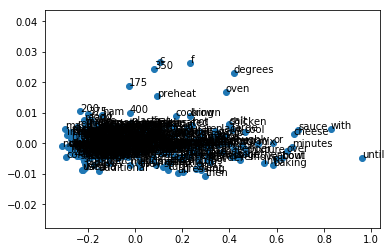

In [380]:
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))


In [381]:
from sklearn import manifold

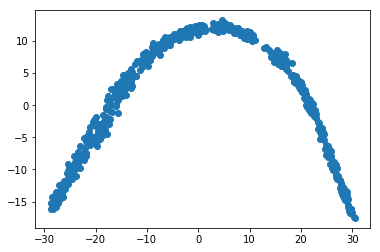

In [391]:
tsne = manifold.TSNE(n_components=2, init='pca', perplexity=30, random_state=0)
tsne_data = tsne.fit_transform(X)
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])

In [389]:
mds = manifold.MDS(2, max_iter=100, n_init=1)
mds_data = mds.fit_transform(X)
plt.scatter(mds_data[:, 0], mds_data[:, 1])

ValueError: Array must be symmetric